In [36]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#Algorithms
from sklearn import ensemble, linear_model
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# permutation_importance
from sklearn.inspection import permutation_importance

from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

In [2]:
file = '/users/yulong/desktop/downsample_training_data.csv'

In [3]:
data = pd.read_csv(file)

In [4]:
data.head()

,pol_id,year,STATE,ZIP5,ZIP4,no_hit,var0415,var0447,var0465,var0590,...,var0244_ind,var0476_ind,var1244_ind,var1235_ind,var1048_ind,var0895_ind,var0942_ind,var0591_ind,var1020_ind,var0477_ind
0,PNH00002007797,2020,PA,19401,2908.0,0,0.030301,0.300903,0.21,0.024603,...,0,0,0,0,1,0,0,0,0,0
1,BHH00001059751,2017,MA,2149,4817.0,0,0.026083,0.437367,0.20,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,PAH00001587890,2019,NJ,7857,1403.0,0,0.044046,0.288608,0.21,0.000000,...,1,0,0,0,1,0,0,0,0,1
3,BHH00001067062,2016,MA,2176,2701.0,0,0.054637,0.496544,0.23,0.003666,...,1,0,0,0,0,0,0,1,0,0
4,PAH00001490167,2019,NJ,8003,1972.0,0,0.084442,0.282537,0.25,0.008954,...,1,0,0,0,0,0,0,0,0,1


In [5]:
X = data.drop(columns=['no_hit','ZIP4','ZIP5','STATE','year','pol_id'])
y = data['no_hit']

In [9]:
data_t = pd.read_csv('/users/yulong/desktop/test_data.csv')
X_t = data_t.drop(columns=['no_hit','ZIP4','ZIP5','STATE','year','pol_id'])
y_t = data_t['no_hit']

# Feature reduction

In [6]:
algs = [xgb.XGBClassifier(),
ensemble.RandomForestClassifier(),
ensemble.GradientBoostingClassifier(),
ensemble.AdaBoostClassifier(),
ensemble.ExtraTreesClassifier(),
linear_model.LogisticRegressionCV(),
linear_model.RidgeClassifierCV(),
]

In [7]:
# Use CV to prevent overfitting, Use ShuffleSplit to maintain the same distribution within cv set. 
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [8]:
def calculate_auc(X,y,alg):
    return np.mean(cross_val_score(alg,X, y, cv=cv, scoring='roc_auc'))

# To justify how many variables you want to job each time. 
def drop_n(X,imp,y,alg,n=100):
    # calculate feature importance
    feat_imp = imp(X,y)
    drop = X.drop(columns=feat_imp.index[:n])
    # calculate validation score
    auc = calculate_auc(drop,y,alg)
    return auc, drop

def spearman(x):
    return abs(stats.spearmanr(x,y)[0])

def spear_imp(data):
    spearman_importance = data.apply(spearman).sort_values()
    return spearman_importance

n use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[05:38:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[05:39:13] WARNING: /Users/tra

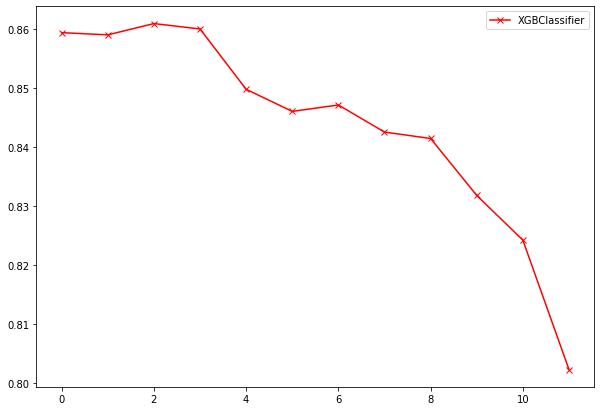

RandomForestClassifier finished


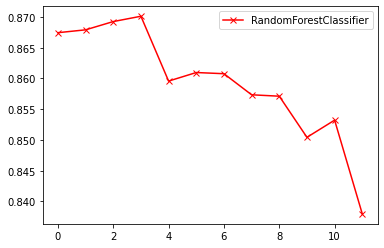

GradientBoostingClassifier finished


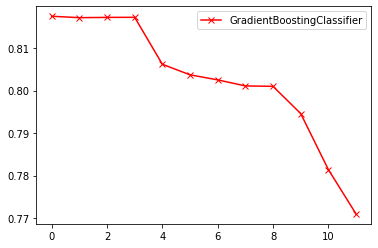

AdaBoostClassifier finished


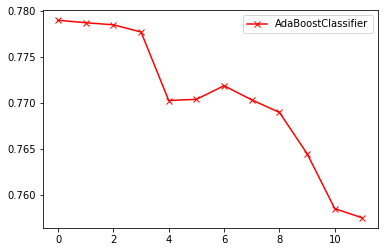

ExtraTreesClassifier finished


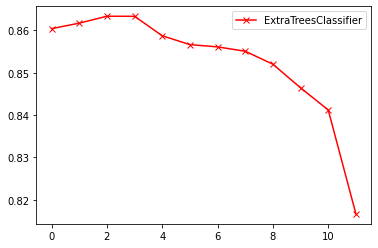

sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/U

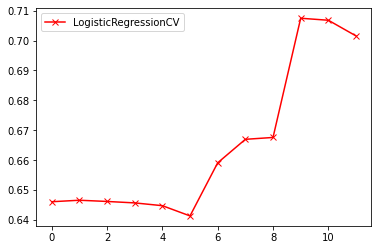

RidgeClassifierCV finished


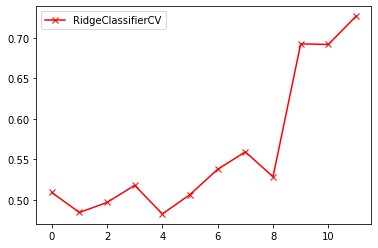

In [14]:
# For training set, the AUC score is based on CV
importance = spear_imp(X)
ks = list(range(12))
fig, ax = plt.subplots(figsize=(10,7))
alg_finals = []
alg_aucs = []
baselines = []

for alg in algs:
    drop_df = X.copy()
    model = alg
    baseline = np.mean(cross_val_score(model, X, y, cv=cv, scoring='roc_auc',n_jobs=-1))
    baselines.append(baseline)
    aucs = []
    n = 0
    while n < 1198:
        drop_df.drop(columns=importance.index[n:n+100], inplace=True)
        auc = calculate_auc(drop_df,y,alg)
        aucs.append((auc, n))
        n+=100
        
    alg_aucs.append(aucs)
    final_model = sorted(aucs, key=lambda tup: tup[0], reverse=True)[0][1]
    alg_finals.append(final_model)

    Alg = alg.__class__.__name__
    print(f'{Alg} finished')

    plt.plot(ks, [x[0] for x in aucs], label=Alg, color='red', marker='x')

    plt.legend()
    plt.show()

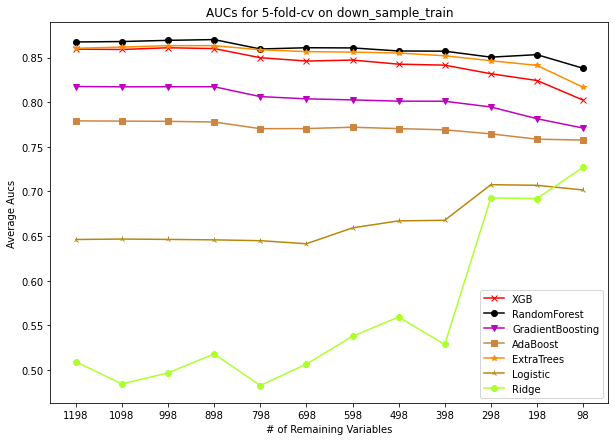

In [30]:
ks = ["1198","1098","998","898","798","698","598","498","398","298","198","98"]
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(ks, [x[0] for x in alg_aucs[0]], label='XGB', color='red', marker='x')
plt.plot(ks, [x[0] for x in alg_aucs[1]], label='RandomForest', color='black', marker='o')
plt.plot(ks, [x[0] for x in alg_aucs[2]], label='GradientBoosting', color='m', marker='v')
plt.plot(ks, [x[0] for x in alg_aucs[3]], label='AdaBoost', color='peru', marker='s')
plt.plot(ks, [x[0] for x in alg_aucs[4]], label='ExtraTrees', color='darkorange', marker='*')
plt.plot(ks, [x[0] for x in alg_aucs[5]], label='Logistic', color='darkgoldenrod', marker='2')
plt.plot(ks, [x[0] for x in alg_aucs[6]], label='Ridge', color='greenyellow', marker='8')
plt.title('AUCs for 5-fold-cv on down_sample_train')
plt.xlabel('# of Remaining Variables')
plt.ylabel('Average Aucs')
plt.legend()
plt.show()

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[03:25:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use

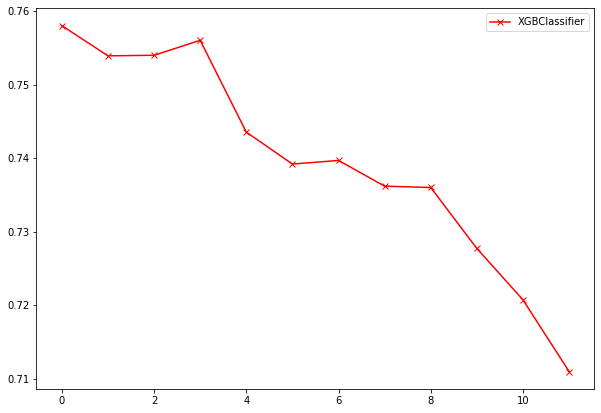

RandomForestClassifier test finished


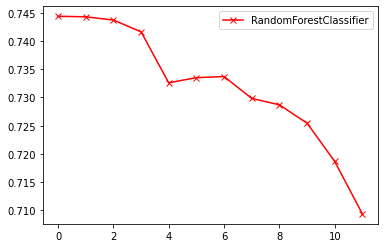

GradientBoostingClassifier test finished


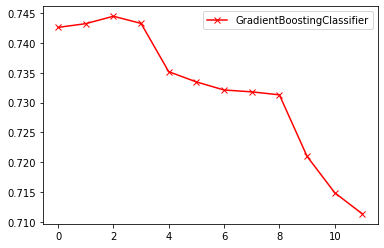

AdaBoostClassifier test finished


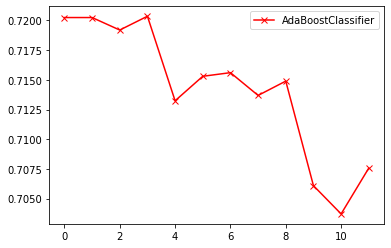

ExtraTreesClassifier test finished


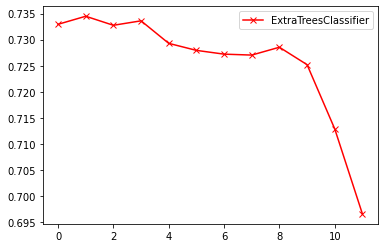

rn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/

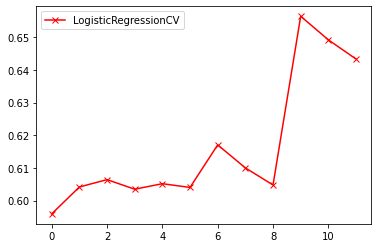

RidgeClassifierCV test finished


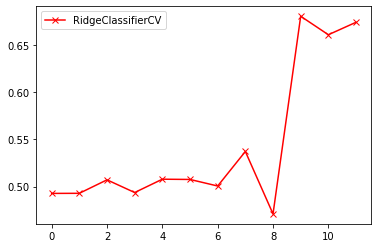

In [13]:
# For test set. AUC is from train on downsample train, predict on AUC test. 
importance = spear_imp(X)
ks = list(range(12))
fig, ax = plt.subplots(figsize=(10,7))
baseline_tests = []
alg_finals_test = []
alg_aucs_test = []

for alg in algs:
    drop_df = X.copy()
    drop_X_t = X_t.copy()

    model = alg
    model.fit(X,y)
    y_pred = model.predict(X_t)
    baseline_test = roc_auc_score(y_t, y_pred)
    baseline_tests.append(baseline_test)
    aucs_test = []
    n = 0
    while n < 1198:
        drop_df.drop(columns=importance.index[n:n+100], inplace=True)
        drop_X_t.drop(columns=importance.index[n:n+100], inplace=True)
        
        model = alg
        model.fit(drop_df,y)
        y_pred = model.predict(drop_X_t)
        
        auc_test = roc_auc_score(y_t, y_pred)
        aucs_test.append((auc_test,n))
        n+=100
        
    
    alg_aucs_test.append(aucs_test)
    final_model_test = sorted(aucs_test, key=lambda tup: tup[0], reverse=True)[0][1]
    alg_finals_test.append(final_model_test)
    Alg = alg.__class__.__name__
    print(f'{Alg} test finished')

    plt.plot(ks, [x[0] for x in aucs_test], label=Alg, color='red', marker='x')

    plt.legend()
    plt.show()


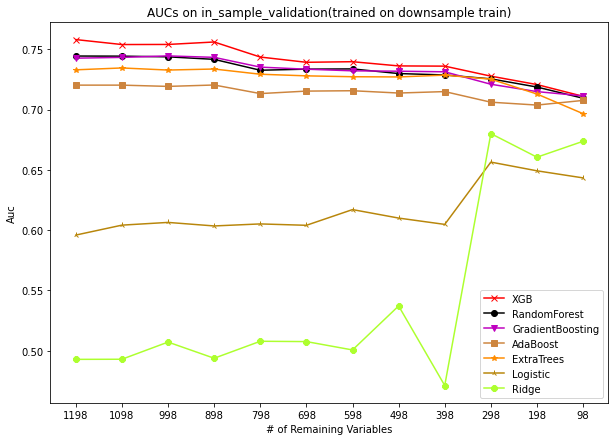

In [28]:
ks = ["1198","1098","998","898","798","698","598","498","398","298","198","98"]
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(ks, [x[0] for x in alg_aucs_test[0]], label='XGB', color='red', marker='x')
plt.plot(ks, [x[0] for x in alg_aucs_test[1]], label='RandomForest', color='black', marker='o')
plt.plot(ks, [x[0] for x in alg_aucs_test[2]], label='GradientBoosting', color='m', marker='v')
plt.plot(ks, [x[0] for x in alg_aucs_test[3]], label='AdaBoost', color='peru', marker='s')
plt.plot(ks, [x[0] for x in alg_aucs_test[4]], label='ExtraTrees', color='darkorange', marker='*')
plt.plot(ks, [x[0] for x in alg_aucs_test[5]], label='Logistic', color='darkgoldenrod', marker='2')
plt.plot(ks, [x[0] for x in alg_aucs_test[6]], label='Ridge', color='greenyellow', marker='8')
plt.title('AUCs on in_sample_validation(trained on downsample train)')
plt.xlabel('# of Remaining Variables')
plt.ylabel('Auc')
plt.legend()
plt.show()

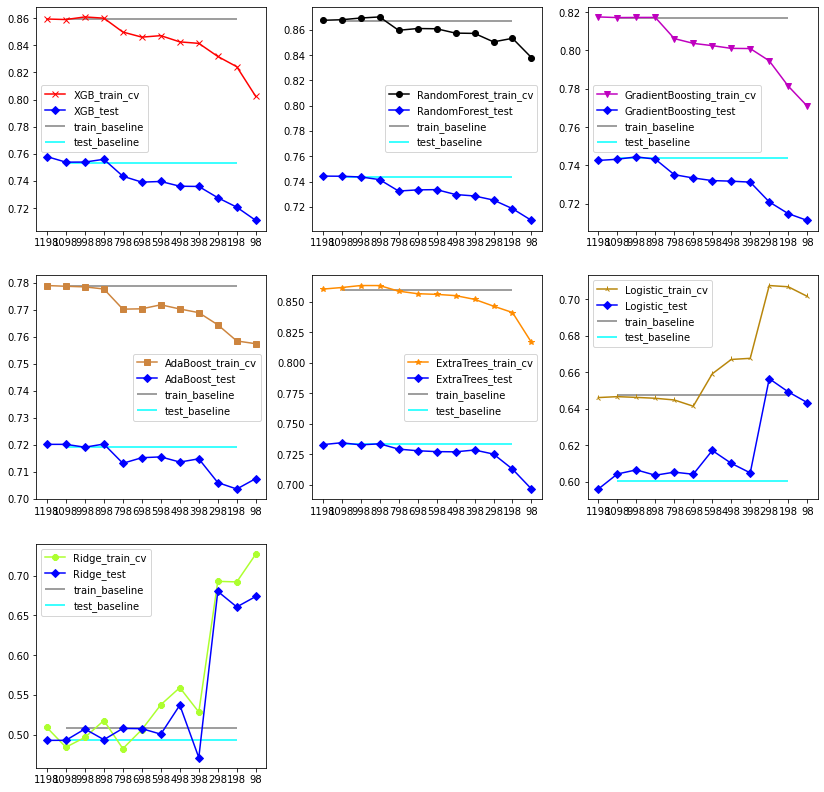

In [34]:
plt.subplots(figsize=(14,14))

plt.subplot(3,3,1)
plt.plot(ks, [x[0] for x in alg_aucs[0]], label='XGB_train_cv', color='red', marker='x')
plt.plot(ks, [x[0] for x in alg_aucs_test[0]], label='XGB_test', color='blue', marker='D')
plt.hlines(baselines[0] , xmin=1, xmax=10,color='grey',label='train_baseline')
plt.hlines(baseline_tests[0] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()

plt.subplot(3,3,2); 
plt.plot(ks, [x[0] for x in alg_aucs[1]], label='RandomForest_train_cv', color='black', marker='o')
plt.plot(ks, [x[0] for x in alg_aucs_test[1]], label='RandomForest_test', color='blue', marker='D')
plt.hlines(baselines[1], xmin=1, xmax=10, color='grey',label='train_baseline')
plt.hlines(baseline_tests[1] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()

plt.subplot(3,3,3); 
plt.plot(ks, [x[0] for x in alg_aucs[2]], label='GradientBoosting_train_cv', color='m', marker='v')
plt.plot(ks, [x[0] for x in alg_aucs_test[2]], label='GradientBoosting_test', color='blue', marker='D')
plt.hlines(baselines[2], xmin=1, xmax=10, color='grey',label='train_baseline')
plt.hlines(baseline_tests[2] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()

plt.subplot(3,3,4); 
plt.plot(ks, [x[0] for x in alg_aucs[3]], label='AdaBoost_train_cv', color='peru', marker='s')
plt.plot(ks, [x[0] for x in alg_aucs_test[3]], label='AdaBoost_test', color='blue', marker='D')
plt.hlines(baselines[3], xmin=1, xmax=10, color='grey',label='train_baseline')
plt.hlines(baseline_tests[3] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()

plt.subplot(3,3,5);
plt.plot(ks, [x[0] for x in alg_aucs[4]], label='ExtraTrees_train_cv', color='darkorange', marker='*')
plt.plot(ks, [x[0] for x in alg_aucs_test[4]], label='ExtraTrees_test', color='blue', marker='D')
plt.hlines(baselines[4], xmin=1, xmax=10, color='grey',label='train_baseline')
plt.hlines(baseline_tests[4] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()

plt.subplot(3,3,6); 
plt.plot(ks, [x[0] for x in alg_aucs[5]], label='Logistic_train_cv', color='darkgoldenrod', marker='2')
plt.plot(ks, [x[0] for x in alg_aucs_test[5]], label='Logistic_test', color='blue', marker='D')
plt.hlines(baselines[5], xmin=1, xmax=10, color='grey',label='train_baseline')
plt.hlines(baseline_tests[5] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()

plt.subplot(3,3,7);
plt.plot(ks, [x[0] for x in alg_aucs[6]], label='Ridge_train_cv', color='greenyellow', marker='8')
plt.plot(ks, [x[0] for x in alg_aucs_test[6]], label='Ridge_test', color='blue', marker='D')
plt.hlines(baselines[6], xmin=1, xmax=10, color='grey',label='train_baseline')
plt.hlines(baseline_tests[6] , xmin=1, xmax=10,color='cyan',label='test_baseline')
plt.legend()
plt.show()

## Permutation importance
* Take too long to run

In [ ]:
# Own function
# def permutation(X,y,alg): 
#     X_train, X_validation, y_train, y_validation = train_test_split(X, y)
    
#     model = alg 
#     model.fit(X_train, y_train)
#     pred = model.predict(X_validation)
#     baseline = roc_auc_score(y_validation,pred)
    
#     permutation_importance = []

#     for column in X.columns:
#         # save the original column because we need to change it back
#         save = X_validation[column].copy()
#         # permute the column
#         X_validation.loc[:, column] = np.random.permutation(X_validation[column])
#         pred = model.predict(X_validation)
#         importance = baseline - roc_auc_score(y_validation, pred)
#         X_validation.loc[:, column] = save
#         permutation_importance.append(importance)

#     permu_imp = pd.DataFrame()
#     permu_imp['Importance'] = permutation_importance
#     permu_imp.index = X.columns
#     permu_imp = permu_imp.sort_values(by='Importance')
#     return permu_imp

In [8]:
# sklearn-permutation_importance
model = xgb.XGBClassifier()
model.fit(X,y)
results = permutation_importance(model, X,y, scoring='roc_auc')

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[22:51:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [8]:
alg_finals = []
alg_alls = []
for alg in algs:
    model = alg
    baseline = np.mean(cross_val_score(model, X, y, cv=5, scoring='roc_auc',n_jobs=-1))

    drop_permu = X.copy()
    select_permu = []

    while len(drop_permu.columns) >100:   
        acc_permu, drop_permu = drop_n(drop_permu,permutation,y,model,n=200)
        select_permu.append((acc_permu, drop_permu))
        
    alg_alls.append(select_permu)
    final_permute = sorted(select_permu, key=lambda tup: tup[0], reverse=True)[0][1]
    alg_finals.append(final_permute)

ue instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a 

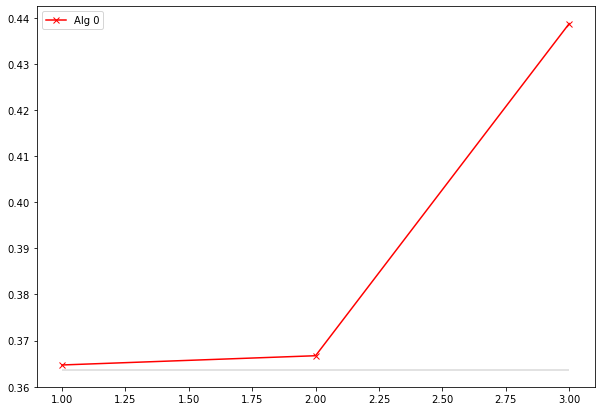

In [27]:
ks = [1,2,3, 4]
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(ks, [x[0] for x in alg_all[0]], label='Alg 0', color='red', marker='x')
ax.hlines(baseline, xmin=1, xmax=3, color='grey', alpha=0.3)

plt.legend()
plt.show()

# Hyper parameter tuning

In [80]:
# Increased CV trying to get better performance
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [81]:
#X_n is for downsample training set for tree based model
#X_n is for downsample training set for ridge.
X_n = X.drop(columns=importance.index[0:400])
X_n_r = X.drop(columns=importance.index[0:1200])

In [ ]:
# This is the X_test set for regression
X_t_r = X_t.drop(columns=importance.index[0:1200])

# This is to creat X_test set for tree model
X_t_t = X_t.drop(columns=importance.index[0:400])

In [82]:
rf_pipe = Pipeline([('randomforestclassifier', ensemble.RandomForestClassifier(n_jobs=-1))])
xgb_pipe = Pipeline([('xgbclassifier', xgb.XGBClassifier())])
pipe_ET = Pipeline([('extratrees', ensemble.ExtraTreesClassifier(n_jobs=-1))])
pipe_ridge = Pipeline([('ridgeclassifier', linear_model.RidgeClassifier())])


rf_hyper = dict(
                randomforestclassifier__n_estimators=[
                    *range(5, 100, 5), *range(100, 500, 100)],
                randomforestclassifier__max_depth=[*range(2, 30), None],
                randomforestclassifier__min_samples_split=range(1, 10),
                randomforestclassifier__min_samples_leaf=range(1, 10),
                randomforestclassifier__max_features=['auto', 'sqrt', 'log2'],
                randomforestclassifier__class_weight=[None, 'balanced'])

xgb_hyper = dict(
                 xgbclassifier__booster=['gbtree', 'gblinear', 'dart'],
                 xgbclassifier__eta=np.arange(0, 1, 0.1),
                 xgbclassifier__gamma=range(0, 10),
                 xgbclassifier__max_depth=range(2, 30),
                 xgbclassifier__subsample=np.arange(0.2, 1, 0.1),
                 xgbclassifier__sampling_method=['uniform', 'gradient_based'])

trees_hyper = dict(extratrees__n_estimators = [5, 10, 50, 100, 200, 300, 400, 500],
                    extratrees__max_depth = [range(2,30), None],
                    extratrees__min_samples_split = range(1,10),
                    extratrees__min_samples_leaf = range(1,10),
                    extratrees__max_features = ['auto', 'sqrt', 'log2'],
                    extratrees__warm_start = [True, False],
                    extratrees__class_weight = [None, 'balanced'])

ridge_hyper = dict(ridgeclassifier__alpha = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 5, 10, 50, 100, 200],
                   ridgeclassifier__solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                   ridgeclassifier__fit_intercept = [True, False],
                   ridgeclassifier__class_weight = [None, 'balanced'])

algorithms = [pipe_ridge,rf_pipe, pipe_ET, xgb_pipe]
hypers = [ridge_hyper,rf_hyper, trees_hyper, xgb_hyper]
algo_name = ['Ridge', 'Random Forest', 'Extra Trees', 'XGB']
best_params = []
for algorithm, hyper, name in zip(algorithms, hypers, algo_name):     
    clf_rand_cv = RandomizedSearchCV(estimator=algorithm,
                                    param_distributions=hyper,
                                    n_iter=50,
                                    cv=cv,
                                    scoring='roc_auc',
                                    n_jobs=-1,
                                    verbose=False)
    if name == 'Ridge':
        clf_rand_cv.fit(X_n_r,y)
    else:
        clf_rand_cv.fit(X_n, y)
    print(f'Best hyperparameters for {name}:')
    print(clf_rand_cv.best_params_, end='\n\n')
    best_params.append(clf_rand_cv.best_params_)

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.12284e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
Best hyperparameters for Ridge:
{'ridgeclassifier__solver': 'auto', 'ridgeclassifier__fit_intercept': True, 'ridgeclassifier__class_weight': None, 'ridgeclassifier__alpha': 0.01}

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.8392733  0.83333414 0.8596927  0.86131329        nan 0.72505084
 0.83546516 0.84738857        nan 0.82391156        nan 0.77215157
 0.82659205 0.85206738 0.82066225 0.85750829 0.8429288         nan
 0.83482339 0.86175892 0.81047728 0.81806254 0.85626637 0.83656677
 0.73763806 0.74936331 0.86657466 0.83952795 0.85894213 0.82819165
 0.7936594  0.75676936 0.81905761 0.86820438 0.85458142 0.83652077
 0.81818819 0.85658307 0.85057731 0.8253

In [83]:
best_params

[{'ridgeclassifier__solver': 'auto',
  'ridgeclassifier__fit_intercept': True,
  'ridgeclassifier__class_weight': None,
  'ridgeclassifier__alpha': 0.01},
 {'randomforestclassifier__n_estimators': 95,
  'randomforestclassifier__min_samples_split': 3,
  'randomforestclassifier__min_samples_leaf': 1,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__max_depth': 28,
  'randomforestclassifier__class_weight': 'balanced'},
 {'extratrees__warm_start': False,
  'extratrees__n_estimators': 500,
  'extratrees__min_samples_split': 5,
  'extratrees__min_samples_leaf': 2,
  'extratrees__max_features': 'auto',
  'extratrees__max_depth': None,
  'extratrees__class_weight': None},
 {'xgbclassifier__subsample': 0.7000000000000002,
  'xgbclassifier__sampling_method': 'uniform',
  'xgbclassifier__max_depth': 26,
  'xgbclassifier__gamma': 3,
  'xgbclassifier__eta': 0.1,
  'xgbclassifier__booster': 'gbtree'}]

In [84]:
alg_final = [
    linear_model.RidgeClassifier(solver=best_params[0].get('ridgeclassifier__solver'),
    fit_intercept=best_params[0].get('ridgeclassifier__fit_intercept'),
    class_weight=best_params[0].get('ridgeclassifier__class_weight'),
    alpha=best_params[0].get('ridgeclassifier__alpha')),
    
    ensemble.RandomForestClassifier(n_jobs=-1,
    n_estimators=best_params[1].get('randomforestclassifier__n_estimators'),
    min_samples_split=best_params[1].get('randomforestclassifier__min_samples_split'),
    min_samples_leaf=best_params[1].get('randomforestclassifier__min_samples_leaf'),
    max_features=best_params[1].get('randomforestclassifier__max_features'),
    max_depth=best_params[1].get('randomforestclassifier__max_depth'),
    class_weight=best_params[1].get('randomforestclassifier__class_weight')),

    ensemble.ExtraTreesClassifier(n_jobs=-1,
    warm_start=best_params[2].get('extratrees__warm_start'),
    n_estimators=best_params[2].get('extratrees__n_estimators'),
    min_samples_split=best_params[2].get('extratrees__min_samples_split'),
    min_samples_leaf=best_params[2].get('extratrees__min_samples_leaf'),
    max_features=best_params[2].get('extratrees__max_features'),
    max_depth=best_params[2].get('extratrees__max_depth'),
    class_weight=best_params[2].get('extratrees__class_weight')),

    xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
    max_depth=best_params[3].get('xgbclassifier__max_depth'),
    gamma=best_params[3].get('xgbclassifier__gamma'),
    eta=best_params[3].get('xgbclassifier__eta'),
    booster=best_params[3].get('xgbclassifier__booster'))
]

In [89]:
auc_tune_result = []

for alg in alg_final:
    if alg.__class__.__name__ == 'RidgeClassifier':
        alg.fit(X_n_r,y)
        pre = alg.predict(X_t_r)
        auc = roc_auc_score(y_t,pre)
        auc_tune_result.append((alg.__class__.__name__,auc))
    else:
        alg.fit(X_n,y)
        pred = alg.predict(X_t_t)
        auc = roc_auc_score(y_t,pred)
        auc_tune_result.append((alg.__class__.__name__,auc))

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.12284e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[01:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [90]:
auc_tune_result

[('RidgeClassifier', 0.6892101539392668),
 ('RandomForestClassifier', 0.7435357367000286),
 ('ExtraTreesClassifier', 0.7387586514783899),
 ('XGBClassifier', 0.7558833747562289)]

In [ ]:
# Ridge 98 0.6736751884932575
# RF 898 0.732591338616328
# ExtraTrees 898 0.7292860498347522
# XGB 898  0.7435373775952104

# Hard voting

In [94]:
from sklearn.ensemble import VotingClassifier

In [118]:
# get a voting ensemble of models
def get_voting():
	# define the base models
    models = list()
    models.append(('Ridge', linear_model.RidgeClassifier(solver=best_params[0].get('ridgeclassifier__solver'),
                    fit_intercept=best_params[0].get('ridgeclassifier__fit_intercept'),
                    class_weight=best_params[0].get('ridgeclassifier__class_weight'),
                    alpha=best_params[0].get('ridgeclassifier__alpha'))))

    models.append(('RF', ensemble.RandomForestClassifier(n_jobs=-1,
                    n_estimators=best_params[1].get('randomforestclassifier__n_estimators'),
                    min_samples_split=best_params[1].get('randomforestclassifier__min_samples_split'),
                    min_samples_leaf=best_params[1].get('randomforestclassifier__min_samples_leaf'),
                    max_features=best_params[1].get('randomforestclassifier__max_features'),
                    max_depth=best_params[1].get('randomforestclassifier__max_depth'),
                    class_weight=best_params[1].get('randomforestclassifier__class_weight'))))

    models.append(('Extratree', ensemble.ExtraTreesClassifier(n_jobs=-1,
                    warm_start=best_params[2].get('extratrees__warm_start'),
                    n_estimators=best_params[2].get('extratrees__n_estimators'),
                    min_samples_split=best_params[2].get('extratrees__min_samples_split'),
                    min_samples_leaf=best_params[2].get('extratrees__min_samples_leaf'),
                    max_features=best_params[2].get('extratrees__max_features'),
                    max_depth=best_params[2].get('extratrees__max_depth'),
                    class_weight=best_params[2].get('extratrees__class_weight'))))


    models.append(('XGB',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'))))
	
	# define the voting ensemble
    vot = VotingClassifier(estimators=models, voting='hard')
    return vot

In [119]:
def get_models():
    models = dict()
    models['Ridge'] = linear_model.RidgeClassifier(solver=best_params[0].get('ridgeclassifier__solver'),
                                                fit_intercept=best_params[0].get('ridgeclassifier__fit_intercept'),
                                                class_weight=best_params[0].get('ridgeclassifier__class_weight'),
                                                alpha=best_params[0].get('ridgeclassifier__alpha'))
    models['RF'] = ensemble.RandomForestClassifier(n_jobs=-1,
                    n_estimators=best_params[1].get('randomforestclassifier__n_estimators'),
                    min_samples_split=best_params[1].get('randomforestclassifier__min_samples_split'),
                    min_samples_leaf=best_params[1].get('randomforestclassifier__min_samples_leaf'),
                    max_features=best_params[1].get('randomforestclassifier__max_features'),
                    max_depth=best_params[1].get('randomforestclassifier__max_depth'),
                    class_weight=best_params[1].get('randomforestclassifier__class_weight'))
    models['Extratree'] = ensemble.ExtraTreesClassifier(n_jobs=-1,
                    warm_start=best_params[2].get('extratrees__warm_start'),
                    n_estimators=best_params[2].get('extratrees__n_estimators'),
                    min_samples_split=best_params[2].get('extratrees__min_samples_split'),
                    min_samples_leaf=best_params[2].get('extratrees__min_samples_leaf'),
                    max_features=best_params[2].get('extratrees__max_features'),
                    max_depth=best_params[2].get('extratrees__max_depth'),
                    class_weight=best_params[2].get('extratrees__class_weight'))
    models['XGB'] = xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'))
    models['hard_voting'] = get_voting()
    return models

In [125]:
def evaluate_model(model, X_n_r, X_t_r,X_n,X_t_t,y):
    if model.__class__.__name__ == 'RidgeClassifier':
        model.fit(X_n_r,y)
        pre = model.predict(X_t_r)
        auc = roc_auc_score(y_t,pre)
    else:
        model.fit(X_n,y)
        pred = model.predict(X_t_t)
        auc = roc_auc_score(y_t,pred)
    return auc

In [126]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_n_r, X_t_r,X_n,X_t_t,y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f ' % (name, scores))

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.12284e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
>Ridge 0.689 
>RF 0.742 
>Extratree 0.739 
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[02:50:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the 

## Check to see combine multiple xgb

In [133]:
def get_voting():
	# define the base models
    models = list()
    
    models.append(('XGB_0',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=0)))
    models.append(('XGB_1',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=1)))
    models.append(('XGB_2',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=2)))
    models.append(('XGB_3',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=3)))
   
	# define the voting ensemble
    vot = VotingClassifier(estimators=models, voting='hard')
    return vot

def get_models():
    models = dict()
    models['hard_voting'] = get_voting()
    return models

def evaluate_model(model,X_n,X_t_t,y):
    model.fit(X_n,y)
    pred = model.predict(X_t_t)
    auc = roc_auc_score(y_t,pred)
    return auc

In [135]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model,X_n,X_t_t,y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f ' % (name, scores))

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:13:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd lik

## Cross result

In [143]:
test_data = pd.read_csv('/users/yulong/desktop/id_test.csv')

In [144]:
test_data.head()

,pol_id,year,STATE,ZIP5,ZIP4,y,var0415,var0447,var0465,var0590,...,var0244_ind,var0476_ind,var1244_ind,var1235_ind,var1048_ind,var0895_ind,var0942_ind,var0591_ind,var1020_ind,var0477_ind
0,PNH00002016383,2019,PA,19380,1336.0,0,0.067088,0.300597,0.31,0.001082,...,0,0,0,0,0,0,0,0,0,0
1,PNH00002005641,2018,PA,19149,1933.0,0,0.035829,0.167966,0.33,0.043070,...,1,0,0,0,1,0,0,0,0,0
2,PNH00002021880,2019,PA,17870,7659.0,1,0.046218,0.245706,0.02,0.038664,...,1,0,0,0,1,0,0,0,0,0
3,BHH10001340552,2016,MA,1342,9704.0,0,0.024896,0.403756,0.06,0.003666,...,1,0,0,0,0,0,0,1,0,0
4,BHH00001095029,2018,MA,1801,4352.0,0,0.043391,0.475838,0.16,0.000208,...,1,0,0,0,0,0,0,0,0,0


In [145]:
X_id = test_data.drop(columns=['y','ZIP4','ZIP5','STATE','year','pol_id'])
y_id = test_data['y']

In [148]:
X_id_r = X_id.drop(columns=importance.index[0:1200])
X_id_t = X_id.drop(columns=importance.index[0:400])

In [149]:
auc_cross_test_result = []

for alg in alg_final:
    if alg.__class__.__name__ == 'RidgeClassifier':
        alg.fit(X_n_r,y)
        pre = alg.predict(X_id_r)
        auc = roc_auc_score(y_id,pre)
        auc_tune_result.append((alg.__class__.__name__,auc))
    else:
        alg.fit(X_n,y)
        pred = alg.predict(X_id_t)
        auc = roc_auc_score(y_id,pred)
        auc_tune_result.append((alg.__class__.__name__,auc))

/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.12284e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/yulong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:48:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [155]:
auc_tune_result
# year model on year test

[('RidgeClassifier', 0.6892101539392668),
 ('RandomForestClassifier', 0.7435357367000286),
 ('ExtraTreesClassifier', 0.7387586514783899),
 ('XGBClassifier', 0.7558833747562289)]

In [153]:
auc_cross_test_result
# year model on id test

[('RidgeClassifier', 0.6340836821952878),
 ('RandomForestClassifier', 0.6538096694859457),
 ('ExtraTreesClassifier', 0.6519795683892691),
 ('XGBClassifier', 0.6660011280380673)]

In [152]:
auc_cross_test_result=[('RidgeClassifier', 0.6340836821952878),
 ('RandomForestClassifier', 0.6538096694859457),
 ('ExtraTreesClassifier', 0.6519795683892691),
 ('XGBClassifier', 0.6660011280380673)]

In [ ]:
best_params = [{'ridgeclassifier__solver': 'auto',
  'ridgeclassifier__fit_intercept': True,
  'ridgeclassifier__class_weight': None,
  'ridgeclassifier__alpha': 0.01},
 {'randomforestclassifier__n_estimators': 95,
  'randomforestclassifier__min_samples_split': 3,
  'randomforestclassifier__min_samples_leaf': 1,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__max_depth': 28,
  'randomforestclassifier__class_weight': 'balanced'},
 {'extratrees__warm_start': False,
  'extratrees__n_estimators': 500,
  'extratrees__min_samples_split': 5,
  'extratrees__min_samples_leaf': 2,
  'extratrees__max_features': 'auto',
  'extratrees__max_depth': None,
  'extratrees__class_weight': None},
 {'xgbclassifier__subsample': 0.7000000000000002,
  'xgbclassifier__sampling_method': 'uniform',
  'xgbclassifier__max_depth': 26,
  'xgbclassifier__gamma': 3,
  'xgbclassifier__eta': 0.1,
  'xgbclassifier__booster': 'gbtree'}]